In [1]:
import numpy as np
import tensorflow as tf
import lightgbm as lgb

from src.loaders.data_loader import load_train_data, load_test_data

In [2]:
raw_df = load_train_data()

In [ ]:
raw_df.head(5)

In [48]:
raw_df.describe()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Day_sin,Day_cos,Hour_sin,Hour_cos,GHI,TARGET_ROLLING_MEAN_3_shift_1,TARGET_ROLLING_MEAN_5_shift_2,TARGET_ROLLING_MEAN_11_shift_5,TARGET_ROLLING_MEAN_23_shift_11,TARGET_ROLLING_MEAN_47_shift_23
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,5.256000e+04,5.256000e+04,5.256000e+04,5.256000e+04,52560.000000,5.256000e+04,5.256000e+04,5.256000e+04,52560.000000,52560.000000
mean,547.000000,11.500000,15.000000,64.344121,234.792371,2.456033,56.793102,9.279928,17.790630,3.460787e-17,-6.056376e-17,-1.165988e-17,-5.578153e-17,226.848323,1.779063e+01,1.779063e+01,1.779063e+01,17.789917,17.783815
std,316.102148,6.922252,15.000143,103.897125,349.684583,1.426874,22.052875,10.179741,25.759955,7.071135e-01,7.071135e-01,7.071135e-01,7.071135e-01,332.664129,2.508394e+01,2.449984e+01,2.219265e+01,16.239636,7.808203
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.590000,-19.000000,0.000000,-9.999907e-01,-9.999630e-01,-1.000000e+00,-1.000000e+00,-111.562132,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,273.000000,5.750000,0.000000,0.000000,0.000000,1.400000,39.697500,1.000000,0.000000,-7.055836e-01,-7.086267e-01,-7.071068e-01,-7.071068e-01,0.000000,3.182639e-13,1.202594e-13,1.744059e-14,3.348380,11.464994
50%,547.000000,11.500000,15.000000,0.000000,0.000000,2.200000,57.600000,9.000000,0.000000,6.432491e-16,4.303538e-03,6.123234e-17,-6.123234e-17,0.000000,1.126176e+00,2.477589e+00,6.995752e+00,14.002652,17.329971
75%,821.000000,17.250000,30.000000,87.000000,469.000000,3.200000,72.770000,17.000000,32.089890,7.055836e-01,7.025275e-01,7.071068e-01,7.071068e-01,422.000000,3.243645e+01,3.245168e+01,3.111110e+01,28.214710,23.648743
max,1094.000000,23.000000,30.000000,528.000000,1059.000000,12.000000,100.000000,35.000000,99.913939,9.999907e-01,1.000000e+00,1.000000e+00,1.000000e+00,1153.000000,9.941395e+01,9.848816e+01,9.307444e+01,72.721051,37.150026


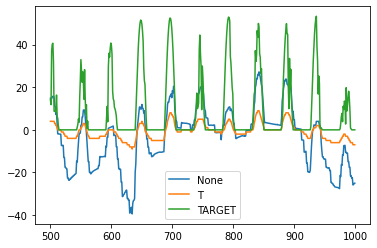

In [42]:
import matplotlib.pyplot as plt
_mean = raw_df["T"].rolling(336).mean()
_std = raw_df["T"].rolling(336).std()
# (raw_df["RH"] )[0:450].plot()
scaled_rh = (raw_df["RH"]) / 100
rh_std = scaled_rh  * (raw_df["T"] - _mean) / _std * 20
rh_std[500:1000].plot()
raw_df["T"][500:1000].plot()
raw_df["TARGET"][500:1000].plot()
plt.legend()

In [6]:
from src.preprocessors.add_columns import add_sin_cos_day, add_sin_cos_hour, add_ghi

def feature_engineering(df):
    df = add_sin_cos_day(df)
    df = add_sin_cos_hour(df)
    df = add_ghi(df)

    df["TARGET_ROLLING_MEAN_3"] = df["TARGET"].rolling(3).mean().fillna(0)
    df["TARGET_ROLLING_MEAN_5"] = df["TARGET"].rolling(5).mean().fillna(0)
    df["TARGET_ROLLING_MEAN_11"] = df["TARGET"].rolling(11).mean().fillna(0)
    df["TARGET_ROLLING_MEAN_23"] = df["TARGET"].rolling(23).mean().fillna(0)
    df["TARGET_ROLLING_MEAN_47"] = df["TARGET"].rolling(47).mean().fillna(0)
    
    scaled_rh = (raw_df["RH"]) / 100
    _mean = raw_df["T"].rolling(96).mean()
    _std = raw_df["T"].rolling(96).std()
    df["SCALED_RH"] = scaled_rh * (raw_df["T"] - _mean) / _std
    
    return df

In [7]:
preprocessed_df = feature_engineering(raw_df)
preprocessed_df.head(5)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Day_sin,Day_cos,Hour_sin,Hour_cos,GHI,TARGET_ROLLING_MEAN_3_shift_1,TARGET_ROLLING_MEAN_5_shift_2,TARGET_ROLLING_MEAN_11_shift_5,TARGET_ROLLING_MEAN_23_shift_11,TARGET_ROLLING_MEAN_47_shift_23
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0,1.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0,1.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0,1.0,0.258819,0.965926,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0,1.0,0.258819,0.965926,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0,1.0,0.500000,0.866025,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
one_day = 48
one_set = one_day * 9

set_df = []
target_df = []
for i in range(len(preprocessed_df) - one_set + 1):
    tmp = preprocessed_df[i:i + one_set]
    
    set_df.append(tmp[:one_day * 7])
    target_df.append(tmp[one_day * 7:])
    
set_df = np.array(set_df)
target_df = np.array(target_df)
set_df.shape, target_df.shape

((52129, 336, 19), (52129, 96, 19))

In [47]:
preprocessed_df.shape

(52560, 19)